In [2]:
#hide
%reload_ext autoreload
%autoreload 2
import logging
from nbdev.showdoc import show_doc
from sdsde.utils.dataframes import display_all
from sdsde.azure.filehandling import unlink_files

In [3]:
# All Imports Needed to Run This Example Notebook
import os
import pandas as pd
import numpy as np
import xgboost as xgb

from sdsde.modeling.inference import pull_sklearn_object_from_data_lake, \
                                    push_dataframe_to_data_lake_as_parquet, move_parquet_table_to_snowflake, \
                                    query_and_push_feature_set_to_data_lake
from sdsde.modeling.inferencefastai import (
    pull_fastai_learner_from_data_lake, pull_transform_predict_sklearn, pull_fastai_preprocess_from_data_lake,
    push_prediction_to_dl_and_sf
)
from sdsde.modeling.premodel import make_data_lake_stage, temporal_and_static_dump_data_to_datalake
from sdsde.modeling.preprocessingfastai import generate_fastai_pytorch_dataloader, load_pandas, save_fastai_preprocess_to_data_lake
from sdsde.modeling.premodel import query_pushed_parquet_table_data_lake, query_feature_set_from_data_lake
from sdsde.modeling.training import HpOptBinary, save_sklearn_object_to_data_lake
from sdsde.modeling.trainingfastai import train_fastai_tabular_model, save_fastai_model_to_data_lake
from sdsde.snowflake.query import SnowflakeConnect
from sdsde.azure.filehandling import FileHandling
from sdsde.utils.traininghelpers import  binary_classification_reporter_sklearn
from sdsde.utils.traininghelpersfastai import binary_classification_reporter_fastai_dl, change_dl_to_pandas_df

from fastai.tabular.core import CategoryBlock, Categorify, FillMissing, Normalize
from fastai.basics import *
from fastai.tabular.all import *
from hyperopt import fmin, tpe, STATUS_OK, Trials, hp, space_eval
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

> Warining: Unless you have a GPU available you will get a CUDA error here and this is okay and shouldn't be a problem for the example, but will lead to slower training times for the Neural Network

# What to Expect

**Question**: 
    
    Who is this notebook for?

**Answer**:

    Anyone with a curiosity in answering a binary question.  

# DataLoader Process

## PreModel

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
load_breast_cancer = datasets.load_breast_cancer()
X = pd.DataFrame(load_breast_cancer['data'], columns=load_breast_cancer['feature_names'])
y = load_breast_cancer['target']
# df['target'] = load_breast_cancer['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1235)

df = X_train.reset_index(drop=True)
df['target'] = y_train
display(df.head())

df_test = X_test.reset_index(drop=True)
df_test['target'] = y_test
display(df_test.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,22.01,21.90,147.20,1482.0,0.10630,0.19540,0.24480,0.15010,0.1824,0.06140,...,25.80,195.00,2227.0,0.1294,0.38850,0.4756,0.24320,0.2741,0.08574,0
1,12.78,16.49,81.37,502.5,0.09831,0.05234,0.03653,0.02864,0.1590,0.05653,...,19.76,85.67,554.9,0.1296,0.07061,0.1039,0.05882,0.2383,0.06410,1
2,11.93,10.91,76.14,442.7,0.08872,0.05242,0.02606,0.01796,0.1601,0.05541,...,20.14,87.64,589.5,0.1374,0.15750,0.1514,0.06876,0.2460,0.07262,1
3,14.95,17.57,96.85,678.1,0.11670,0.13050,0.15390,0.08624,0.1957,0.06216,...,21.43,121.40,971.4,0.1411,0.21640,0.3355,0.16670,0.3414,0.07147,0
4,13.98,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,...,30.80,113.90,869.3,0.1613,0.35680,0.4069,0.18270,0.3179,0.10550,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,12.450,16.41,82.85,476.7,0.09514,0.15110,0.15440,0.04846,0.2082,0.07325,...,21.03,97.82,580.6,0.1175,0.4061,0.4896,0.13420,0.3231,0.10340,1
1,13.170,21.81,85.42,531.5,0.09714,0.10470,0.08259,0.05252,0.1746,0.06177,...,29.89,105.50,740.7,0.1503,0.3904,0.3728,0.16070,0.3693,0.09618,0
2,20.470,20.67,134.70,1299.0,0.09156,0.13130,0.15230,0.10150,0.2166,0.05419,...,27.15,152.00,1645.0,0.1097,0.2534,0.3092,0.16130,0.3220,0.06386,0
3,13.690,16.07,87.84,579.1,0.08302,0.06374,0.02556,0.02031,0.1872,0.05669,...,20.21,99.16,670.6,0.1105,0.2096,0.1346,0.06987,0.3323,0.07701,1
4,9.676,13.14,64.12,272.5,0.12550,0.22040,0.11880,0.07038,0.2057,0.09575,...,18.04,69.47,328.1,0.2006,0.3663,0.2913,0.10750,0.2848,0.13640,1


In [6]:
dl_train, tab_train = generate_fastai_pytorch_dataloader(df, cat_vars=[], cont_vars=list(load_breast_cancer['feature_names']), 
                                                         y_var=['target'], y_block=CategoryBlock(), y_range=None,
                                                         val_pct=0.2, bs=100, procs = [FillMissing, Normalize],
                                                         seed=123, splits=None)

INFO:sdsde.modeling.preprocessingfastai:Training Data Size 410
INFO:sdsde.modeling.preprocessingfastai:Validation Data Size 102
INFO:sdsde.modeling.preprocessingfastai:Categorical Variable(s) For Project []
INFO:sdsde.modeling.preprocessingfastai:Continuous Variable(s) For Project ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
INFO:sdsde.modeling.preprocessingfastai:Dependent Variable(s) For Project ['target']
INFO:sdsde.modeling.preprocessingfastai:dataloader being 

# Model Training

## DL Based Non-Custom Model

### Train DL Model

In this section you will:

1. Tabular Neural Network (``train_fastai_tabular_model``)

2. Report on how well or unwell the model did for your data set (``binary_classification_reporter_fastai_dl``)

INFO:sdsde.modeling.trainingfastai:Learning Rate Suggestion SuggestedLRs(valley=0.007585775572806597)


epoch,train_loss,valid_loss,recall_score,accuracy,f1_score,roc_auc_score,balanced_accuracy_score,time
0,0.619676,0.549731,1.000000,0.735294,0.823529,0.982499,0.653846,00:00
1,0.456165,0.421063,1.000000,0.941176,0.954545,0.988197,0.923077,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.6538461538461539.


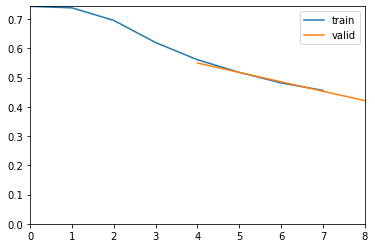

Better model found at epoch 1 with balanced_accuracy_score value: 0.9230769230769231.


INFO:root:Percent Predicted Set 0.676%
INFO:root:Percent Predicted Set at 0.5 threshold 0.676%


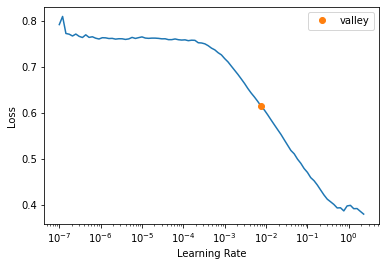

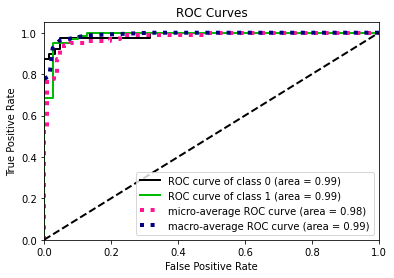

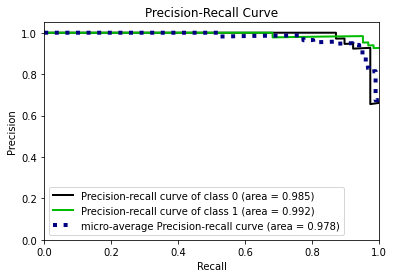

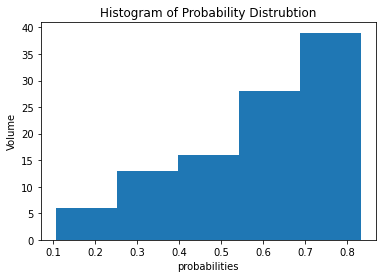

INFO:root:Percent Return Actual Set 0.618%
INFO:root:Accuracy For Each Class
INFO:root:[0.84615385 1.        ]
INFO:root:[[33  6]
 [ 0 63]]
INFO:root:              precision    recall  f1-score   support

           0       1.00      0.85      0.92        39
           1       0.91      1.00      0.95        63

    accuracy                           0.94       102
   macro avg       0.96      0.92      0.94       102
weighted avg       0.95      0.94      0.94       102

INFO:root:Accuracy For Each Class 0.4 Cut Off for Model
INFO:root:[0.84615385 1.        ]
INFO:root:[[33  6]
 [ 0 63]]
INFO:root:              precision    recall  f1-score   support

           0       1.00      0.85      0.92        39
           1       0.91      1.00      0.95        63

    accuracy                           0.94       102
   macro avg       0.96      0.92      0.94       102
weighted avg       0.95      0.94      0.94       102

INFO:root:AUC 0.9881969881969882


(0.9881969881969882, 0.9230769230769231)

In [7]:
learn, probs, y, loss = train_fastai_tabular_model(dl = dl_train, 
                                                   layer_sizes = [50, 10],
                                                   metrics = [Recall(), accuracy, F1Score(), RocAucBinary(), BalancedAccuracy()],
                                                   epochs = 2,
                                                   wd=0.2,
                                                   model_name = 'sdsde_test_dl_model_fast.pkl',
                                                   save_metric_monitor = 'balanced_accuracy_score',
                                                   save_comp = np.greater,
                                                   early_metric_monitor = 'balanced_accuracy_score',
                                                   early_comp = np.greater,
                                                   early_min_delta = 1e-5,
                                                   patience = 5,
                                                   project_location='projects/model-runs/latest/classification/models/dl/',
                                                   y_range = None, # for regression
                                                   plot=True)

# Uncomment line below to review model arch if you are interested in seeing what a NN arch looks like
learn.summary()

binary_classification_reporter_fastai_dl(probs, y=y, threshold=0.5, plot=True, bins=5)

### Predict on Test Set

INFO:root:Percent Predicted Set 0.702%
INFO:root:Percent Predicted Set at 0.5 threshold 0.702%


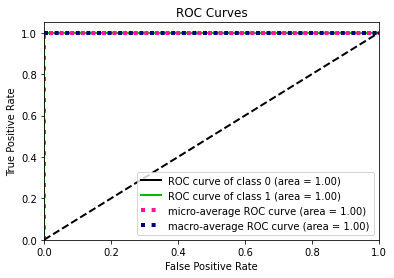

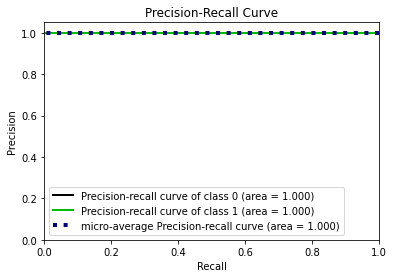

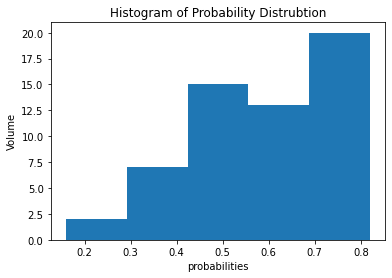

INFO:root:Percent Return Actual Set 0.702%
INFO:root:Accuracy For Each Class
INFO:root:[1. 1.]
INFO:root:[[17  0]
 [ 0 40]]
INFO:root:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        40

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

INFO:root:Accuracy For Each Class 0.4 Cut Off for Model
INFO:root:[1. 1.]
INFO:root:[[17  0]
 [ 0 40]]
INFO:root:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        40

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

INFO:root:AUC 1.0


(1.0, 1.0)

In [8]:
test_dl = learn.dls.test_dl(df_test, with_label=True)
probs, _ = learn.get_preds(dl=test_dl)

results = pd.DataFrame(probs, columns=load_breast_cancer['target_names'])
results['pred'] = np.where(results.benign > 0.5, 1, 0)
binary_classification_reporter_fastai_dl(probs, y=results.pred, threshold=0.5, plot=True, bins=5)

## Tree Based Algo Based Approach XgBoost Example

### Transform DataLoader To Pandas DataFrame

In [9]:
data_sets = change_dl_to_pandas_df(dl_train)

X_train, y_train, X_valid, y_valid = data_sets

X_train.shape, len(y_train), X_valid.shape, len(y_valid)

INFO:root:Label size 410
INFO:root:Training/Test set shape (410, 30)
INFO:root:Validation set shape (102, 30)
INFO:root:Label size 102


((410, 30), 410, (102, 30), 102)

### Hyper Tuning With HyperOpt Xgbost SklearnAPI

To use the tree based method we will use it exactly  the same to this point as [LTPB Project](https://gitlab.com/VailResorts/data-science/ltbp/-/blob/master/Notebooks/Likelihood-to-buy-pass-autoML-example.ipynb) with a slight difference in what you are actually saving.

> Note: When saving a xgboost model with our the sklearn API wrapper it will be wise to save the parameters chosen from the hyperopt search in case something happens to the model and there is a need to retrain the model. **Remember that hyper opt is searching dynamically and will almost never give you the exact parameter space**
>> *Parameter Space* the commented out three parameters make extreme differences to the feature importance of the model, which is just for information. (Comeback another time to see if a write up on this is here)

  0%|     | 0/2 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006039 seconds
INFO:hyperopt.tpe:TPE using 0 trials


[18:00:08] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
 50%|▌| 1/2 [00:00<00:00,  2.99trial/s, best los

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004185 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.008954


[18:00:08] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
100%|█| 2/2 [00:00<00:00,  3.45trial/s, best los
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.59,
              enable_categorical=False, eval_metric='auc',
              gamma=3.1372802164625027, gpu_id=0, importance_type=None,
              interaction_constraints=None, learning_rate=0.11310863823457956,
              max_delta_step=None, max_depth=12, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.9, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
[18:00:08] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gp

INFO:sdsde.utils.traininghelpers:predicting set
INFO:sdsde.utils.traininghelpers:Percent Return Predicted Set 0.608%
INFO:sdsde.utils.traininghelpers:Percent Return Actual Set 0.618%
INFO:sdsde.utils.traininghelpers:Accuracy For Each Class
INFO:sdsde.utils.traininghelpers:[0.8974359  0.92063492]
INFO:sdsde.utils.traininghelpers:[[35  4]
 [ 5 58]]
INFO:sdsde.utils.traininghelpers:              precision    recall  f1-score   support

           0       0.88      0.90      0.89        39
           1       0.94      0.92      0.93        63

    accuracy                           0.91       102
   macro avg       0.91      0.91      0.91       102
weighted avg       0.91      0.91      0.91       102

INFO:sdsde.utils.traininghelpers:AUC 0.9778184778184779


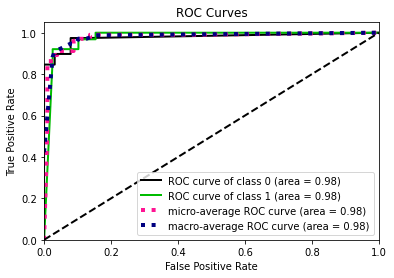

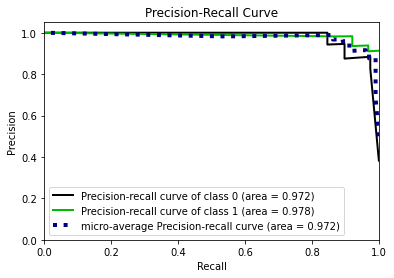

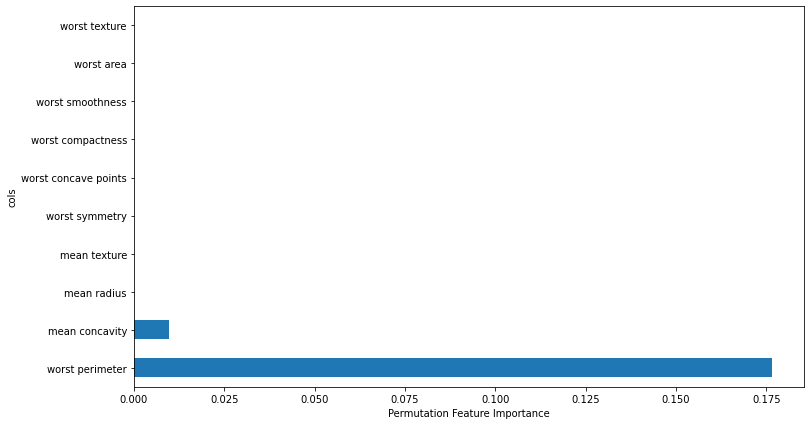

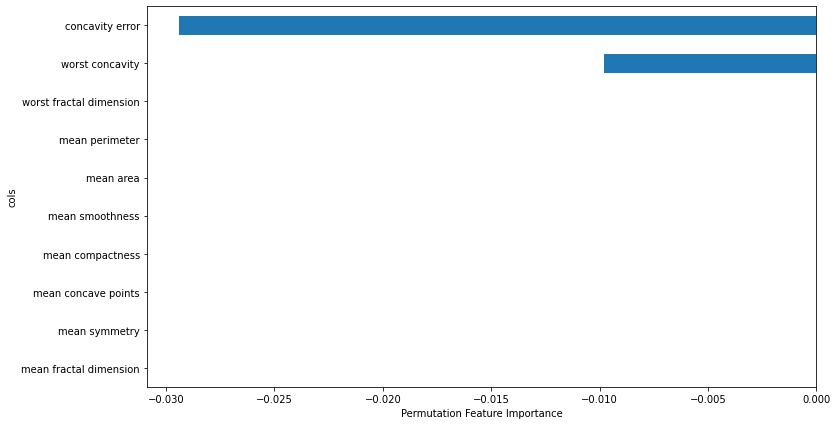

In [10]:
parameter_space = {
    'max_depth': hp.choice('max_depth', np.arange(21, dtype=int) + 3),
    'gamma': hp.uniform('gamma', 0, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.01),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'objective': hp.choice('objective', ['binary:logistic', 'binary:logitraw', 'binary:hinge']),
    'eval_metric': hp.choice('eval_metric', ['logloss', 'error', 'auc', 'aucpr', 'map']),
    'use_label_encoder': hp.choice('use_label_encoder', [False]),
    'gpu_id': hp.choice('gpu_id', [0]),
}
opt = HpOptBinary(X_train, X_valid, y_train, y_valid, parameter_space=parameter_space)
best = opt.optimize(max_evals=2)
model = xgb.XGBClassifier(**best)
print(model)
eval_set  = [(X_valid, y_valid.values)]
model.fit(X_train, y_train.values, eval_set= eval_set, eval_metric ='auc', early_stopping_rounds = 2)

threshold = 0.5 if model.base_score is None else model.base_score

report = binary_classification_reporter_sklearn(m=model, x=X_valid, y=y_valid, threshold=0.5, 
                                                          plot=True, feature_importance=True)

probs, preds, val_auc, val_bal_acc, fi_permutation = report

### Predict on Test

INFO:sdsde.utils.traininghelpers:predicting set
INFO:sdsde.utils.traininghelpers:Percent Return Predicted Set 0.614%
INFO:sdsde.utils.traininghelpers:Percent Return Actual Set 0.632%
INFO:sdsde.utils.traininghelpers:Accuracy For Each Class
INFO:sdsde.utils.traininghelpers:[0.85714286 0.88888889]
INFO:sdsde.utils.traininghelpers:[[18  3]
 [ 4 32]]
INFO:sdsde.utils.traininghelpers:              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.91      0.89      0.90        36

    accuracy                           0.88        57
   macro avg       0.87      0.87      0.87        57
weighted avg       0.88      0.88      0.88        57

INFO:sdsde.utils.traininghelpers:AUC 0.9285714285714286


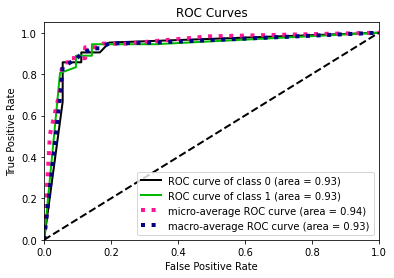

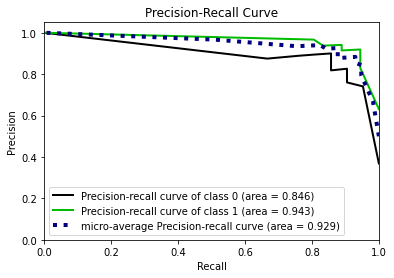

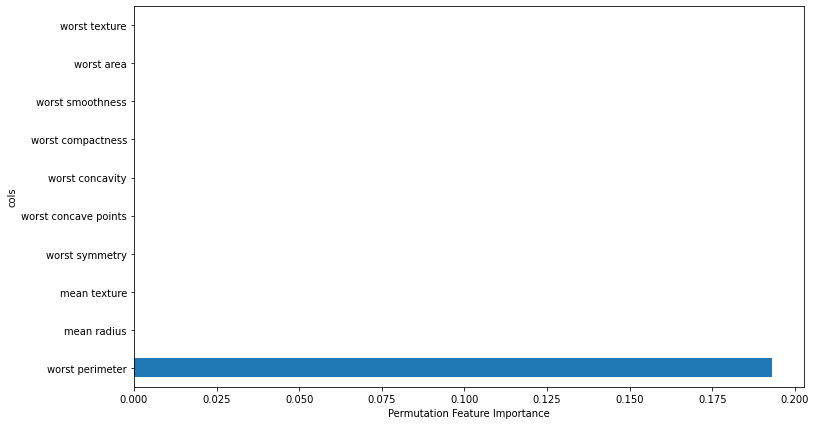

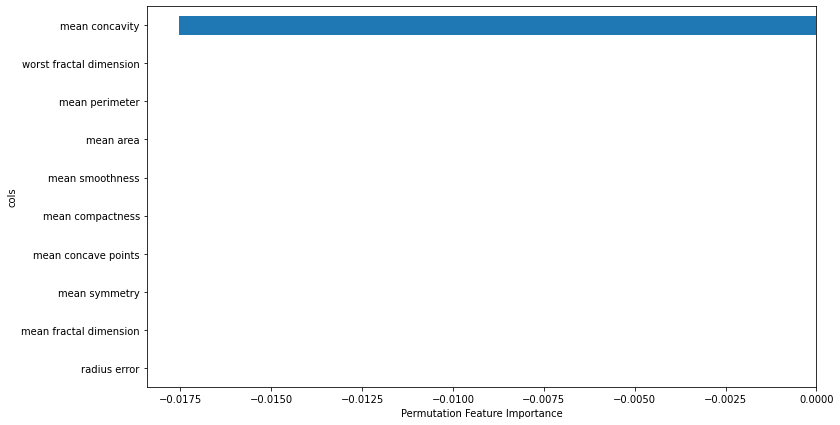

In [11]:
dl_test = tab_train.train.new(df_test)
dl_test.process()

X_test = dl_test.xs
y_test = dl_test.y

assert X_test.shape[0] == y_test.shape[0], 'y_test and x_test have different number of rows'

probs = model.predict_proba(X_test)
preds = model.predict(X_test)

results = pd.DataFrame(probs, columns=load_breast_cancer['target_names'])
results['pred'] = np.where(results.benign > 0.5, 1, 0)
results.head()

report = binary_classification_reporter_sklearn(m=model, x=X_test, y=y_test, threshold=0.5, 
                                                plot=True, feature_importance=True)

# Clean Up Example

In [13]:
shutil.rmtree('./projects')